##Educação em geofísica
Material didático - algoritmos para aulas de geofísica
#Realce de anomalias - Derivadas em x, y e z

Citação deste material: Szameitat, L.S.A., Bongiolo, A.B.S. (in prep.). Educação em geofísica: recursos computacionais para tratamento de dados magnetométricos e gravimétricos em sala de aula. Boletim Paranaense de Geociências.

####Referencias
#####• Blakely, R. (1996). Potential Theory in Gravity and Magnetic Applications.Cambridge University, 464p.

Importar bibliotecas

In [ ]:
import numpy as np
import scipy.fftpack
from math import radians, sin, cos, sqrt
import matplotlib.pyplot as plt
import pandas as pd

#Funções
Funções para trabalhar com os dados do campo magnético anômalo, com base nos algoritmos de Blakely (1996).

In [ ]:
from numpy.lib.nanfunctions import nanmax
def Kvalue(i, j, nx, ny, dkx, dky):
    '''
    Parametros
    ----------
    i, j - indices
    nx, ny -  numero de amostras em x e y
    dkx, dky -
    '''
    nyqx = nx / 2 + 1
    nyqy = ny / 2 + 1
    kx = float()
    ky = float()
    if j <= nyqx:
        kx = (j-1) * dkx
    else:
        kx = (j-nx-1) * dkx
    if i <= nyqy:
        ky = (i-1) * dky
    else:
        ky = (i-ny-1) * dky
    return kx, ky

def Derivada(vetor, axis, nx, ny, dkx, dky):
    # FFT, entrada grid de 2 dimensões
    grid = np.reshape(vetor, (ny, nx)) #de 1D para 2D
    gridfft = scipy.fftpack.fft2(grid)
    # Grid - de matriz para vetor
    gridfft = np.reshape(gridfft, ny*nx)
    # Cria um vetor complexo
    gridfft_filt = np.zeros(ny*nx).astype(complex)
    if axis == 'z':
        for j in range(1, ny+1):
            for i in range(1, nx+1):
                ij = (j-1) * nx + i
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky)
                k = sqrt(kx**2 + ky**2)
                gridfft_filt[ij-1] = gridfft[ij-1]*k**1 #filtro
    elif axis == 'y':
        for j in range(1, ny+1):
            for i in range(1, nx+1):
                ij = (j-1) * nx + i
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky)
                k = kx
                gridfft_filt[ij-1] = gridfft[ij-1]*k*complex(0, 1)
    elif axis == 'x':
        for j in range(1, ny+1):
            for i in range(1, nx+1):
                ij = (j-1) * nx + i
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky)
                k = ky
                gridfft_filt[ij-1] = gridfft[ij-1]*k*complex(0, 1)
    else:
        return print ('Tipo não suportado: ', axis)

    #iFFT, entrada como matriz 2D
    gridfft_filt = np.reshape(gridfft_filt, (ny, nx))
    gridfft_filt = scipy.fftpack.ifft2(gridfft_filt)
    #retorna para 1D, para saida como vetor
    vetor_out = np.reshape(gridfft_filt.real, (ny*nx))

    return vetor_out


#Arquivo de entrada
Carregar arquivo de dados no ambiente. O arquivo deve conter colunas de coordenadas (x,y) e campo anômalo.

In [ ]:
#Opção 1 - Arquivo para exercício

arquivo = 'https://raw.githubusercontent.com/lszam/ensino/main/geof_filtros/davi.csv'

#Opção 2 - Arquivo próprio
#from google.colab import files
#import io

#uploaded=files.upload()
#arquivo = ' ' #inserir o nome do arquivo

Abrir e visualizar o arquivo de entrada:

In [ ]:
dados = pd.read_csv(arquivo, delimiter = ",")
dados

,LESTE,NORTE,ANOM
0,652198,7284826,0.0
1,652298,7284826,0.0
2,652398,7284826,0.0
3,652498,7284826,0.0
4,652598,7284826,0.0
...,...,...,...
12683,663898,7295126,-0.0
12684,663998,7295126,-0.0
12685,664098,7295126,-0.0
12686,664198,7295126,-0.0


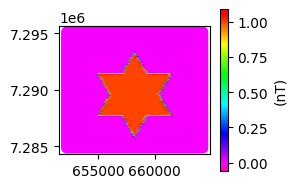

In [ ]:
#Plotar mapa
plt.figure(figsize=(3, 3))  #tamanho da figura
entrada_anom = plt.scatter(dados.LESTE, dados.NORTE, c=dados.ANOM, cmap='gist_rainbow_r')
plt.colorbar(entrada_anom, label="(nT)", shrink=0.6) #barra de cores
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

*Organizando os grids de entrada, obter informações do grid.*

In [ ]:
# .to_numpy() converte os valores de dentro da série tipo Pandas em um array NumPy
vetor_LESTE = dados.LESTE.to_numpy()
vetor_NORTE = dados.NORTE.to_numpy()
vetor_ANOM = dados.ANOM.to_numpy()

#Elementos a leste e a norte, não repetidos
pontos_LESTE=[]
pontos_NORTE=[]
[pontos_LESTE.append(item) for item in vetor_LESTE if not pontos_LESTE.count(item)]
[pontos_NORTE.append(item) for item in vetor_NORTE if not pontos_NORTE.count(item)]

#Salvar número de itens a leste e a norte
nx = np.size(pontos_LESTE)
ny = np.size(pontos_NORTE)

#Obter a distancia em x e y
dX, dY = np.abs(pontos_LESTE[0]-pontos_LESTE[1]), np.abs(pontos_NORTE[0]-pontos_NORTE[1])

#Derivadas em X, Y e Z

In [ ]:
π = np.pi
dkx = 2. * π / (nx * dX)
dky = 2. * π / (ny * dY)

# Filtros Derivadas(), entrada com vetor
vetor_DX1 = Derivada(vetor_ANOM, 'x', nx, ny, dkx, dky)
vetor_DY1 = Derivada(vetor_ANOM, 'y', nx, ny, dkx, dky)
vetor_DZ1 = Derivada(vetor_ANOM, 'z', nx, ny, dkx, dky)

#Adicionar no dataframe
dados = dados.assign(DX1 = vetor_DX1)
dados = dados.assign(DY1 = vetor_DY1)
dados = dados.assign(DZ1 = vetor_DZ1)
dados

,LESTE,NORTE,ANOM,DX1,DY1,DZ1
0,652198,7284826,0.0,-4.000795e-20,-3.917527e-19,-0.000327
1,652298,7284826,0.0,-1.337535e-19,-4.811147e-19,-0.000327
2,652398,7284826,0.0,-9.806697e-20,-2.976262e-19,-0.000326
3,652498,7284826,0.0,-2.128087e-19,-6.345600e-19,-0.000326
4,652598,7284826,0.0,-2.117966e-19,-1.520424e-19,-0.000326
...,...,...,...,...,...,...
12683,663898,7295126,-0.0,-3.214851e-19,2.436279e-19,-0.000326
12684,663998,7295126,-0.0,-1.170921e-19,1.986292e-19,-0.000326
12685,664098,7295126,-0.0,-1.977302e-19,3.919116e-19,-0.000326
12686,664198,7295126,-0.0,-2.590143e-19,6.649209e-20,-0.000326


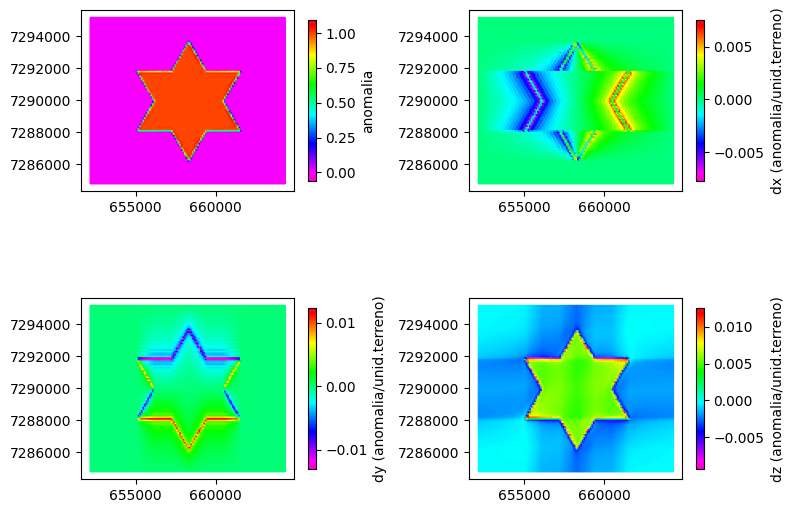

In [ ]:
# Plotar mapas
plt.figure(figsize=(8, 6))

plt.subplot(2,2,1)
mapa_anom = plt.scatter(dados.LESTE, dados.NORTE, c=dados.ANOM, cmap='gist_rainbow_r', s=1.2)
plt.colorbar(mapa_anom, label="anomalia", shrink=0.6) #barra de cores
plt.gca().set_aspect("equal")
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em formato "não-científico"


plt.subplot(2,2,2)
mapa_dx = plt.scatter(dados.LESTE, dados.NORTE, c=dados.DX1, cmap='gist_rainbow_r', s=1.2)
plt.colorbar(mapa_dx, label="dx (anomalia/unid.terreno)", shrink=0.6)
plt.gca().set_aspect("equal")
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em formato "não-científico"

plt.subplot(2,2,3)
mapa_dy = plt.scatter(dados.LESTE, dados.NORTE, c=dados.DY1, cmap='gist_rainbow_r', s=1.2)
plt.colorbar(mapa_dy, label="dy (anomalia/unid.terreno)", shrink=0.6)
plt.gca().set_aspect("equal")
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em formato "não-científico"

plt.subplot(2,2,4)
mapa_dz = plt.scatter(dados.LESTE, dados.NORTE, c=dados.DZ1, cmap='gist_rainbow_r', s=1.2)
plt.colorbar(mapa_dz, label="dz (anomalia/unid.terreno)", shrink=0.6)
plt.gca().set_aspect("equal")
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em formato "não-científico"

plt.tight_layout()
plt.savefig('derivadas_py.png', dpi=300, bbox_inches='tight')
plt.show()

Salvar a saída como arquivo csv

In [ ]:
dados.to_csv("derivadas_py.csv")